# Are you on PC or MAC? pc = 0, mac = 1

In [1]:
computer = 1

# IF YOU RUN THIS PAGE FOR THE FIRST TIME : 

# START HERE

# OTHERWISE, YOU CAN START BELOW TO AVOID FETCHING ALL THE DATA AGAIN

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [3]:
ROOTPATH = os.getcwd()
path = os.path.join(ROOTPATH, 'Data')

if not os.path.exists(path):
    os.makedirs(path)


# 1) This first part is only accessing in a list all the tickers in our fund, via a csv

In [4]:
# In the file IBB_holdings.csv, the tickers are sorted by descending weigths as of 5-Feb-18
# The file contains a lot of information about the fund IBB as of 5-Feb-18, which can be imported via row[i], i being the column you want
# For now we only import the first column, tickers.

if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
else:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile, delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c >= 11:
                list_tickers.append(row[0].split(',')[0])
            c+=1
            
list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")

# 2) We now want to download the data of all tickers as dataframes

In [5]:
# Setting up the variables

start_date = '2016-01-01'
end_date = '2018-01-01'


nb_tickers = len(list_tickers)
list_dataframes=[None]*(nb_tickers)

In [6]:
#On Yahoo
still_missing = nb_tickers
passages = 0

while still_missing > 0 and passages < 100:
    passages += 1
    print("harvest number " , passages)
    for i in range (nb_tickers ):
        if type(list_dataframes[i]) == type(None):   
            symbol = list_tickers[i]
            try:
                df = web.DataReader(symbol, 'yahoo' , start_date ,end_date)
                list_dataframes[i] = df
                still_missing -= 1
            except:
                print("Oops!  That was no valid ticker.  Try again... "+list_tickers[i])

harvest number  1
Oops!  That was no valid ticker.  Try again... ABUS
Oops!  That was no valid ticker.  Try again... ACAD
Oops!  That was no valid ticker.  Try again... ACHN
Oops!  That was no valid ticker.  Try again... ACOR
Oops!  That was no valid ticker.  Try again... ACRS
Oops!  That was no valid ticker.  Try again... ADAP
Oops!  That was no valid ticker.  Try again... ADMS
Oops!  That was no valid ticker.  Try again... ADRO
Oops!  That was no valid ticker.  Try again... AERI
Oops!  That was no valid ticker.  Try again... AGIO
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again... AKAO
Oops!  That was no valid ticker.  Try again... AKBA
Oops!  That was no valid ticker.  Try again... AKCA
Oops!  That was no valid ticker.  Try again... ALDR
Oops!  That was no valid ticker.  Try again... ALKS
Oops!  That was no valid ticker.  Try again... ALNY
Oops!  That was no valid ticker.  Try again... ALXN
Oops!  That was no valid ticker.  Try again...

Oops!  That was no valid ticker.  Try again... CELG
Oops!  That was no valid ticker.  Try again... CERS
Oops!  That was no valid ticker.  Try again... CHRS
Oops!  That was no valid ticker.  Try again... CLDX
Oops!  That was no valid ticker.  Try again... CLLS
Oops!  That was no valid ticker.  Try again... CLVS
Oops!  That was no valid ticker.  Try again... CLXT
Oops!  That was no valid ticker.  Try again... CMRX
Oops!  That was no valid ticker.  Try again... CNCE
Oops!  That was no valid ticker.  Try again... COLL
Oops!  That was no valid ticker.  Try again... CORI
Oops!  That was no valid ticker.  Try again... CRBP
Oops!  That was no valid ticker.  Try again... CRIS
Oops!  That was no valid ticker.  Try again... CRSP
Oops!  That was no valid ticker.  Try again... CRVS
Oops!  That was no valid ticker.  Try again... CTMX
Oops!  That was no valid ticker.  Try again... CYTK
Oops!  That was no valid ticker.  Try again... DBVT
Oops!  That was no valid ticker.  Try again... DEPO
Oops!  That 

Oops!  That was no valid ticker.  Try again... COLL
Oops!  That was no valid ticker.  Try again... CORI
Oops!  That was no valid ticker.  Try again... CRBP
Oops!  That was no valid ticker.  Try again... CRIS
Oops!  That was no valid ticker.  Try again... CRSP
Oops!  That was no valid ticker.  Try again... CRVS
Oops!  That was no valid ticker.  Try again... CTMX
Oops!  That was no valid ticker.  Try again... CYTK
Oops!  That was no valid ticker.  Try again... DBVT
Oops!  That was no valid ticker.  Try again... DEPO
Oops!  That was no valid ticker.  Try again... DERM
Oops!  That was no valid ticker.  Try again... DOVA
Oops!  That was no valid ticker.  Try again... ECYT
Oops!  That was no valid ticker.  Try again... EDIT
Oops!  That was no valid ticker.  Try again... EGRX
Oops!  That was no valid ticker.  Try again... ENDP
Oops!  That was no valid ticker.  Try again... ENTA
Oops!  That was no valid ticker.  Try again... EPZM
Oops!  That was no valid ticker.  Try again... ESPR
Oops!  That 

Oops!  That was no valid ticker.  Try again... RTRX
Oops!  That was no valid ticker.  Try again... RVNC
Oops!  That was no valid ticker.  Try again... SAGE
Oops!  That was no valid ticker.  Try again... SBBP
Oops!  That was no valid ticker.  Try again... SCMP
Oops!  That was no valid ticker.  Try again... SGEN
Oops!  That was no valid ticker.  Try again... SGMO
Oops!  That was no valid ticker.  Try again... SGYP
Oops!  That was no valid ticker.  Try again... SHPG
Oops!  That was no valid ticker.  Try again... SNDX
Oops!  That was no valid ticker.  Try again... SNNA
Oops!  That was no valid ticker.  Try again... SPPI
Oops!  That was no valid ticker.  Try again... SRPT
Oops!  That was no valid ticker.  Try again... SUPN
Oops!  That was no valid ticker.  Try again... SVRA
Oops!  That was no valid ticker.  Try again... SYNH
Oops!  That was no valid ticker.  Try again... TBPH
Oops!  That was no valid ticker.  Try again... TECH
Oops!  That was no valid ticker.  Try again... TLGT
Oops!  That 

Oops!  That was no valid ticker.  Try again... ANAB
Oops!  That was no valid ticker.  Try again... ANIP
Oops!  That was no valid ticker.  Try again... ARDX
Oops!  That was no valid ticker.  Try again... ARNA
Oops!  That was no valid ticker.  Try again... ARRY
Oops!  That was no valid ticker.  Try again... ARWR
Oops!  That was no valid ticker.  Try again... ASND
Oops!  That was no valid ticker.  Try again... ATNX
Oops!  That was no valid ticker.  Try again... ATRA
Oops!  That was no valid ticker.  Try again... AUPH
Oops!  That was no valid ticker.  Try again... AVDL
Oops!  That was no valid ticker.  Try again... AVXS
Oops!  That was no valid ticker.  Try again... AXON
Oops!  That was no valid ticker.  Try again... BCRX
Oops!  That was no valid ticker.  Try again... BGNE
Oops!  That was no valid ticker.  Try again... BIIB
Oops!  That was no valid ticker.  Try again... BIVV
Oops!  That was no valid ticker.  Try again... BLCM
Oops!  That was no valid ticker.  Try again... BLUE
Oops!  That 

Oops!  That was no valid ticker.  Try again... ANIP
Oops!  That was no valid ticker.  Try again... ARDX
Oops!  That was no valid ticker.  Try again... ARNA
Oops!  That was no valid ticker.  Try again... ARRY
Oops!  That was no valid ticker.  Try again... ARWR
Oops!  That was no valid ticker.  Try again... ASND
Oops!  That was no valid ticker.  Try again... ATNX
Oops!  That was no valid ticker.  Try again... ATRA
Oops!  That was no valid ticker.  Try again... AUPH
Oops!  That was no valid ticker.  Try again... AVDL
Oops!  That was no valid ticker.  Try again... AVXS
Oops!  That was no valid ticker.  Try again... AXON
Oops!  That was no valid ticker.  Try again... BCRX
Oops!  That was no valid ticker.  Try again... BGNE
Oops!  That was no valid ticker.  Try again... BIIB
Oops!  That was no valid ticker.  Try again... BIVV
Oops!  That was no valid ticker.  Try again... BLCM
Oops!  That was no valid ticker.  Try again... BLUE
Oops!  That was no valid ticker.  Try again... BMRN
Oops!  That 

Oops!  That was no valid ticker.  Try again... ACRS
Oops!  That was no valid ticker.  Try again... ADAP
Oops!  That was no valid ticker.  Try again... ADMS
Oops!  That was no valid ticker.  Try again... ADRO
Oops!  That was no valid ticker.  Try again... AERI
Oops!  That was no valid ticker.  Try again... AGIO
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again... AKAO
Oops!  That was no valid ticker.  Try again... AKBA
Oops!  That was no valid ticker.  Try again... AKCA
Oops!  That was no valid ticker.  Try again... ALDR
Oops!  That was no valid ticker.  Try again... ALKS
Oops!  That was no valid ticker.  Try again... ALNY
Oops!  That was no valid ticker.  Try again... ALXN
Oops!  That was no valid ticker.  Try again... AMAG
Oops!  That was no valid ticker.  Try again... AMGN
Oops!  That was no valid ticker.  Try again... AMPH
Oops!  That was no valid ticker.  Try again... AMRN
Oops!  That was no valid ticker.  Try again... ANAB
Oops!  That 

Oops!  That was no valid ticker.  Try again... ENTA
Oops!  That was no valid ticker.  Try again... EPZM
Oops!  That was no valid ticker.  Try again... ESPR
Oops!  That was no valid ticker.  Try again... EXEL
Oops!  That was no valid ticker.  Try again... FGEN
Oops!  That was no valid ticker.  Try again... FLXN
Oops!  That was no valid ticker.  Try again... FMI
Oops!  That was no valid ticker.  Try again... FOLD
Oops!  That was no valid ticker.  Try again... FOMX
Oops!  That was no valid ticker.  Try again... FPRX
Oops!  That was no valid ticker.  Try again... GBT
Oops!  That was no valid ticker.  Try again... GERN
Oops!  That was no valid ticker.  Try again... GHDX
Oops!  That was no valid ticker.  Try again... GILD
Oops!  That was no valid ticker.  Try again... GLPG
Oops!  That was no valid ticker.  Try again... GLYC
Oops!  That was no valid ticker.  Try again... GRFS
Oops!  That was no valid ticker.  Try again... GTHX
Oops!  That was no valid ticker.  Try again... GWPH
Oops!  That wa

Oops!  That was no valid ticker.  Try again... VNDA
Oops!  That was no valid ticker.  Try again... VRTX
Oops!  That was no valid ticker.  Try again... VTL
Oops!  That was no valid ticker.  Try again... VYGR
Oops!  That was no valid ticker.  Try again... XLRN
Oops!  That was no valid ticker.  Try again... XNCR
Oops!  That was no valid ticker.  Try again... ZGNX
harvest number  64
Oops!  That was no valid ticker.  Try again... ABUS
Oops!  That was no valid ticker.  Try again... ACAD
Oops!  That was no valid ticker.  Try again... ACHN
Oops!  That was no valid ticker.  Try again... ACOR
Oops!  That was no valid ticker.  Try again... ACRS
Oops!  That was no valid ticker.  Try again... ADAP
Oops!  That was no valid ticker.  Try again... ADMS
Oops!  That was no valid ticker.  Try again... ADRO
Oops!  That was no valid ticker.  Try again... AERI
Oops!  That was no valid ticker.  Try again... AGIO
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again...

Oops!  That was no valid ticker.  Try again... OMER
Oops!  That was no valid ticker.  Try again... ONCE
Oops!  That was no valid ticker.  Try again... OPK
Oops!  That was no valid ticker.  Try again... PACB
Oops!  That was no valid ticker.  Try again... PBYI
Oops!  That was no valid ticker.  Try again... PCRX
Oops!  That was no valid ticker.  Try again... PDLI
Oops!  That was no valid ticker.  Try again... PETQ
Oops!  That was no valid ticker.  Try again... PETX
Oops!  That was no valid ticker.  Try again... PGNX
Oops!  That was no valid ticker.  Try again... PRAH
Oops!  That was no valid ticker.  Try again... PRTA
Oops!  That was no valid ticker.  Try again... PRTK
Oops!  That was no valid ticker.  Try again... PTCT
Oops!  That was no valid ticker.  Try again... PTLA
Oops!  That was no valid ticker.  Try again... QURE
Oops!  That was no valid ticker.  Try again... RARE
Oops!  That was no valid ticker.  Try again... RARX
Oops!  That was no valid ticker.  Try again... RDUS
Oops!  That w

harvest number  81
Oops!  That was no valid ticker.  Try again... ABUS
Oops!  That was no valid ticker.  Try again... ACAD
Oops!  That was no valid ticker.  Try again... ACHN
Oops!  That was no valid ticker.  Try again... ACOR
Oops!  That was no valid ticker.  Try again... ACRS
Oops!  That was no valid ticker.  Try again... ADAP
Oops!  That was no valid ticker.  Try again... ADMS
Oops!  That was no valid ticker.  Try again... ADRO
Oops!  That was no valid ticker.  Try again... AERI
Oops!  That was no valid ticker.  Try again... AGIO
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again... AKAO
Oops!  That was no valid ticker.  Try again... AKBA
Oops!  That was no valid ticker.  Try again... AKCA
Oops!  That was no valid ticker.  Try again... ALDR
Oops!  That was no valid ticker.  Try again... ALKS
Oops!  That was no valid ticker.  Try again... ALNY
Oops!  That was no valid ticker.  Try again... ALXN
Oops!  That was no valid ticker.  Try again..

Oops!  That was no valid ticker.  Try again... PACB
Oops!  That was no valid ticker.  Try again... PBYI
Oops!  That was no valid ticker.  Try again... PCRX
Oops!  That was no valid ticker.  Try again... PDLI
Oops!  That was no valid ticker.  Try again... PETQ
Oops!  That was no valid ticker.  Try again... PETX
Oops!  That was no valid ticker.  Try again... PGNX
Oops!  That was no valid ticker.  Try again... PRAH
Oops!  That was no valid ticker.  Try again... PRTA
Oops!  That was no valid ticker.  Try again... PRTK
Oops!  That was no valid ticker.  Try again... PTCT
Oops!  That was no valid ticker.  Try again... PTLA
Oops!  That was no valid ticker.  Try again... QURE
Oops!  That was no valid ticker.  Try again... RARE
Oops!  That was no valid ticker.  Try again... RARX
Oops!  That was no valid ticker.  Try again... RDUS
Oops!  That was no valid ticker.  Try again... REGN
Oops!  That was no valid ticker.  Try again... RETA
Oops!  That was no valid ticker.  Try again... RGEN
Oops!  That 

harvest number  96
Oops!  That was no valid ticker.  Try again... ABUS
Oops!  That was no valid ticker.  Try again... ACAD
Oops!  That was no valid ticker.  Try again... ACHN
Oops!  That was no valid ticker.  Try again... ACOR
Oops!  That was no valid ticker.  Try again... ACRS
Oops!  That was no valid ticker.  Try again... ADAP
Oops!  That was no valid ticker.  Try again... ADMS
Oops!  That was no valid ticker.  Try again... ADRO
Oops!  That was no valid ticker.  Try again... AERI
Oops!  That was no valid ticker.  Try again... AGIO
Oops!  That was no valid ticker.  Try again... AIMT
Oops!  That was no valid ticker.  Try again... AKAO
Oops!  That was no valid ticker.  Try again... AKBA
Oops!  That was no valid ticker.  Try again... AKCA
Oops!  That was no valid ticker.  Try again... ALDR
Oops!  That was no valid ticker.  Try again... ALKS
Oops!  That was no valid ticker.  Try again... ALNY
Oops!  That was no valid ticker.  Try again... ALXN
Oops!  That was no valid ticker.  Try again..

# 3) Finally, we can download in a new folder all this information for future use, to avoid downloading them from the web again

In [7]:
#Download of the dataframes as as many csv's (for now)

for i in range (nb_tickers ):  
    file_name = 'csv_' + list_tickers[i] + '_from_' + start_date + '_to_' + end_date + ".csv"
    string = path + '\\' + file_name
    list_dataframes[i].to_csv(string , sep=',')

# 4) This program is not (yet) collecting the two tickers that are not equities : BLKFDS and USD

# 5) We also need a benchmark

In [8]:
# Here the benchmark is NASDAQ Biotechnology index 
symbol='^NBI'
benchmark1 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

In [9]:
# Here the benchmark is iShares Nasdaq Biotechnology ETF 
symbol='IBB'
benchmark2 = web.DataReader(symbol, 'yahoo' , start_date ,end_date)

# 6) Now we need rate of returns

In [10]:
df_ror_1 = benchmark1['High'].pct_change()
df_ror_2 = benchmark2['High'].pct_change()

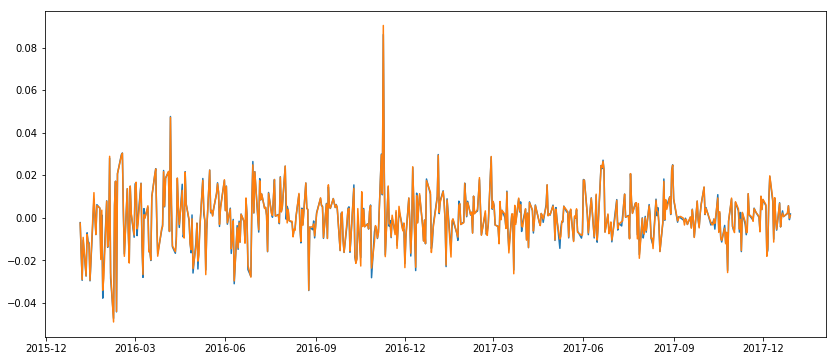

In [11]:
# Both benchmarks should have similar rate of returns, though they have different prices
plt.plot(df_ror_1)
plt.hold
plt.plot(df_ror_2)
plt.show;

In [12]:
def rateOfReturnWeekly(df,column):
    # Column has to be a column of the dataframe (ie 'Open','AdjClose')
    
    # Making sure dataframe is well sorted
    df_sorted = df.sort_index( ascending = True )
    

    # So far gives daily as shift = 1!
    shift = 1
    df_shifted = df_sorted.shift(shift)
    rate_of_returns = (df_sorted - df_shifted) / df_shifted
    rate_of_returns = rate_of_returns.drop(rate_of_returns.index[0])

    return rate_of_returns

# 7) Function to add noise to a dataframe (a new dataframe will be created)

In [13]:
def add_noise_2(df_origin, tick, mean = 0, std = 0.005):
    noise = []
    
    # Creating the noise
    for i in range(len(df_origin)):
        x = np.exp(np.random.normal(mean,std))
        noise.append(x)
        
    df_modified = df_origin.copy()
    df_modified['Adj Close'] = df_modified['Adj Close'].multiply(noise)
    
    file_name = 'csv_' + tick + '_B_' + str(mean) + '_' + str(std) + '_from_' + start_date + '_to_' + end_date + '.csv'
    string = path + file_name
    df_modified.to_csv(os.path.join(path,file_name), sep=',') 

# 8) Create all the new csv

In [14]:
allFiles = glob.glob(path + "/csv" + "*.csv")


i=0
if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1
    
if computer == 1:    
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            if list_tickers[i] != 'SNDX':
                df = pd.read_csv(csvfile, index_col=None, header=0)
                add_noise_2(df,list_tickers[i],0,0.01)
                #add_noise_2(df,list_tickers[i],0,0.008)
                #add_noise_2(df,list_tickers[i],0,0.0003)
                #add_noise_2(df,list_tickers[i],0,0.002)
                #add_noise_2(df,list_tickers[i],0,0.0006)
            i=i+1

# IF YOU RUN THIS PAGE FOR THE SECOND TIME : 

# START HERE

# Are you on PC or MAC? pc = 0, mac = 1

In [7]:
computer = 1

In [8]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas_datareader.data as web
import datetime
import pandas as pd
import os
import csv
import glob as glob
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from time import time

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

In [9]:
# Comprehensive way to set the path to Data directory

ROOTPATH = os.getcwd()

if not(ROOTPATH[-4:] == 'Data'):
    path = os.path.join(ROOTPATH, 'Data')
else:
    path = ROOTPATH

In [10]:
if computer == 0:
    with open('IBB_holdings.csv', 'r') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1

if computer == 1:
    with open('IBB_holdings.csv', 'r', encoding ='mac_roman') as csvfile:
        file = csv.reader(csvfile,delimiter=' ')
        c=0
        list_tickers=[]
        for row in file:
            if c>=11:
                list_tickers.append(row[0].split(',')[0])
            c+=1            

list_tickers.sort()
list_tickers.pop()
list_tickers.remove("BLKFDS")
list_tickers.remove("USD")
list_tickers.remove("SNDX")

In [46]:
nb_tickers = len(list_tickers)
list_dataframes=[None]*(nb_tickers) #SNDX


allFiles = glob.glob(path + "/csv" + "*.csv")
i = 0

if computer == 0:
    for file_ in allFiles:
        with open(file_, 'r') as csvfile:
            list_dataframes[i] = pd.read_csv(csvfile, index_col=None, header=0)
            i+=1

if computer == 1:
    for file_ in allFiles:
        with open(file_, 'r', encoding ='mac_roman') as csvfile:
            list_dataframes[i] = pd.read_csv(csvfile, index_col=None, header=0)
            i += 1
            
            
            
maxi = 0
length = 0
compt = 0
j = 0

for df in list_dataframes:
    if len(df)>maxi:
        maxi = len(df['Adj Close'])

data = np.array([np.zeros(maxi)]*(nb_tickers)) 


for df in list_dataframes:
    arr = np.array(df['Adj Close'])
    if len(arr) == maxi and not df['Adj Close'].isnull().values.any():    
        minimum = np.min(arr)
        maximum = np.max(arr)
        arr = (arr - minimum) / (maximum - minimum)
        data[j] = arr
        j += 1
    else :
        compt += 1            
    

data = data[:-compt]  

np.random.shuffle(data)   

train_set = data[:-50]
test_set = data[-50:-25]
validation_set = data[-25:]

In [47]:
len(data)

169

In [48]:
len(test_set) + len(train_set) + len(validation_set)

169

# 9) Set up the autoencoder

In [49]:
def next_batch(batch_size, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.array(data_shuffle), np.array(labels_shuffle)

In [69]:
# Training Parameters
learning_rate = 0.001
num_steps = 300
batch_size = 10
lambd = 0.1

display_step = 100

# Network Parameters 

num_hidden_1 = 250 # 1st layer num features
#num_hidden_2 = 200 # 2nd layer num features (the latent dim)
num_input = 503 # 503 days considered


In [70]:
X = tf.placeholder("float", [None, num_input])
learning = tf.placeholder("float")
keep_prob = tf.placeholder(tf.float32) #gateway for dropout

In [71]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1],mean=0.0,
    stddev=1.0/np.sqrt(num_input))),
    #'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2],mean=0.0,
    #stddev=1.0/np.sqrt(num_hidden_1))),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_1, num_input],mean=0.0,
    stddev=1.0/np.sqrt(num_hidden_1))),
    #'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input],mean=0.0,
    #stddev=1.0/np.sqrt(num_hidden_1))),
}
biases = {
    'encoder_b1': tf.Variable(tf.zeros([num_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.zeros([num_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

In [72]:
# Building the encoder
def encoder(x,dropout):
    # x = tf.nn.dropout(x, dropout)
    # Encoder Hidden layer with relu activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with relu activation #2
    #layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
    #                               biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x, dropout):
    x = tf.nn.dropout(x, dropout)
    # Decoder Hidden layer with relu activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with relu activation #2
    #layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
    #                               biases['decoder_b2']))
    return layer_1

In [73]:
# Construct model
encoder_op = encoder(X, keep_prob)
decoder_op = decoder(encoder_op, keep_prob)

In [74]:
# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
#mse = tf.pow(y_true - y_pred, 2)
#loss = tf.reduce_sum(mse)

mse = tf.squared_difference(y_pred, y_true)

In [75]:
regularizer = tf.nn.l2_loss(weights['encoder_h1'])
#regularizer += tf.nn.l2_loss(weights['encoder_h2'])
regularizer += tf.nn.l2_loss(weights['decoder_h1'])
#regularizer += tf.nn.l2_loss(weights['decoder_h2'])
#loss = tf.reduce_mean(mse + lambd * regularizer)
loss = tf.reduce_sum(mse + lambd * regularizer)/(num_input * 10)

#Replace learning_rate by learning to get an adaptative learning rate
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 10) Train the autoencoder

In [76]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

costs = []

init_learn =  0.001
inter_learn = 0.0001
final_learn = 0.00001

learn = init_learn

dropout = .9

start_time = time()

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    total_batch = int(len(train_set)/batch_size)
    
    for j in range(total_batch):
        mini_batch_x, _ = next_batch(batch_size,train_set,train_set)

        # Run optimization op (backprop) and cost op (to get loss value)
        if i==2000:
            learn = inter_learn
        elif i==4000:
            learn = final_learn

        _, l = sess.run([optimizer, loss], feed_dict={X: mini_batch_x, learning : learn,  keep_prob : dropout})
        costs.append(l)
        
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))
        curr_time = time()
        elapsed_time = curr_time-start_time
        print('Estimated remaining time = ', elapsed_time / i * (num_steps-i),'s\n')

Step 1: Minibatch Loss: 28.223028
Estimated remaining time =  42.20919585227966 s

Step 100: Minibatch Loss: 0.047950
Estimated remaining time =  9.424415588378906 s

Step 200: Minibatch Loss: 0.073303
Estimated remaining time =  4.567294359207153 s

Step 300: Minibatch Loss: 0.058322
Estimated remaining time =  0.0 s



In [77]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 10

for i in range(n):
    # MNIST test set
    batch_x, _ = next_batch(10,test_set,test_set)
    # Encode and decode the digit image)
    l , p = sess.run([loss,y_pred] , feed_dict={X: batch_x,  keep_prob : 1})
    print('Minibatch Loss: ', l)    

Minibatch Loss:  0.0528658
Minibatch Loss:  0.0559373
Minibatch Loss:  0.0591453
Minibatch Loss:  0.0588923
Minibatch Loss:  0.0571306
Minibatch Loss:  0.0577732
Minibatch Loss:  0.049603
Minibatch Loss:  0.0488407
Minibatch Loss:  0.0541364
Minibatch Loss:  0.0546015


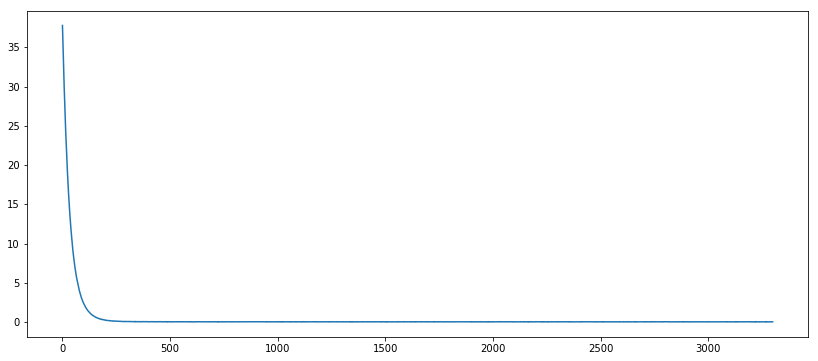

In [78]:
plt.plot(costs)
plt.show()

In [79]:
for i in p:
    print(i)

[ 0.58171219  0.57074928  0.52546531  0.470534    0.45279989  0.40146282
  0.4239679   0.35589597  0.38697341  0.36722836  0.33668697  0.36920407
  0.35952777  0.38957357  0.37348223  0.37038872  0.33167204  0.30888841
  0.32502282  0.32430547  0.29868588  0.29247463  0.29687011  0.26387942
  0.21514103  0.21812327  0.21823394  0.2091362   0.23007999  0.25467515
  0.29071906  0.26309595  0.27718249  0.27607733  0.24669839  0.2522563
  0.25407362  0.26776302  0.24510856  0.27686012  0.3052232   0.29909104
  0.29873538  0.3278597   0.28487504  0.28196648  0.26507089  0.28222594
  0.29238915  0.24775793  0.23836607  0.23389316  0.25532562  0.2686533
  0.28922793  0.25054732  0.25419778  0.24668159  0.27528402  0.27300078
  0.29479682  0.31227952  0.32712269  0.31726956  0.3675566   0.35273796
  0.34171912  0.32666409  0.33416399  0.35881624  0.3623462   0.36320531
  0.37663907  0.36117539  0.36180118  0.38551632  0.39843178  0.38704351
  0.3688947   0.3581965   0.34929523  0.3304913   0.3

[ 0.58193612  0.5709095   0.52565902  0.47070411  0.45293605  0.40161991
  0.42412898  0.35610038  0.38716343  0.36745021  0.33691233  0.36941174
  0.35973844  0.38974431  0.37368497  0.37059528  0.33188236  0.30908433
  0.32521561  0.32454485  0.29888734  0.29271576  0.29714182  0.26415077
  0.21540983  0.21838856  0.21850847  0.20934151  0.23026836  0.25486535
  0.29086962  0.26326624  0.27731004  0.27630627  0.24684891  0.25239581
  0.25419873  0.26786268  0.24520552  0.27690983  0.30533046  0.29915461
  0.29882613  0.32799521  0.2850107   0.28209493  0.26521388  0.28237659
  0.29252177  0.24787629  0.23846768  0.23397727  0.25541431  0.26875594
  0.28934574  0.25069356  0.25431213  0.24678303  0.27540463  0.27310446
  0.29490337  0.31240433  0.3272638   0.31741697  0.36768508  0.35289127
  0.34187365  0.32681224  0.33436093  0.35898462  0.36252311  0.36334574
  0.37677267  0.36129537  0.36190554  0.38565642  0.39861149  0.38719025
  0.36906981  0.35833654  0.34940761  0.33060762  0

In [80]:
print((1 - np.count_nonzero(p)/np.size(p))*100,"%  \'0\' values in prediction")

0.0 %  '0' values in prediction


In [ ]:
for i in batch_x:
    print(i)

[ 0.35285532  0.33867514  0.32087918  0.25948533  0.23360747  0.19471112
  0.2528044   0.18576131  0.2143078   0.16062417  0.12185348  0.16884797
  0.14061115  0.16924144  0.16376682  0.14686631  0.0867903   0.0734334
  0.08533195  0.11692809  0.06218321  0.07288031  0.0938011   0.04808548
  0.          0.02287153  0.01075673  0.00405453  0.02290765  0.03680391
  0.064884    0.04881448  0.0491935   0.06117006  0.13960602  0.13843062
  0.11296907  0.12309047  0.10437779  0.12523879  0.17019313  0.14224796
  0.16200729  0.16461859  0.1510776   0.15149073  0.13214692  0.16151323
  0.16248621  0.11490555  0.06595251  0.08509584  0.09633536  0.11296561
  0.15049133  0.1082442   0.09410687  0.07891024  0.07953517  0.10220099
  0.12749899  0.13022596  0.18308869  0.18486181  0.29087038  0.25530763
  0.27750733  0.28058784  0.2867353   0.32668906  0.34208913  0.32870963
  0.36884047  0.38736837  0.4298429   0.45657603  0.43108793  0.44632369
  0.42020349  0.42678361  0.40934766  0.38372722  0.

[ 0.98626191  1.          0.92336634  0.8404547   0.81201468  0.72899308
  0.76181728  0.67149205  0.70852762  0.71402618  0.65820763  0.69274497
  0.70203     0.72897621  0.70691888  0.67249484  0.62617325  0.61237079
  0.62174084  0.56224202  0.58013727  0.53982124  0.57192725  0.52935851
  0.48302665  0.4851964   0.47730098  0.4775806   0.50093656  0.52405254
  0.55165182  0.50252506  0.53600979  0.52206972  0.49673105  0.5055488
  0.50229051  0.50458189  0.49949133  0.51641765  0.58154551  0.59654254
  0.59304285  0.654077    0.60994703  0.57558996  0.51819249  0.53818587
  0.59289194  0.51366217  0.5158945   0.51375411  0.54101434  0.57211719
  0.60381464  0.55680374  0.53547706  0.54238451  0.59170251  0.58367385
  0.61581345  0.63882998  0.67651004  0.65202994  0.72544007  0.69912261
  0.66724428  0.65542438  0.63925792  0.67596469  0.67018095  0.67350367
  0.6913319   0.67703068  0.66077433  0.66832747  0.67661678  0.65770595
  0.61131841  0.61457868  0.60152677  0.46519366  0.

In [ ]:
for i in p:
    print(i)

[ 0.58171219  0.57074928  0.52546531  0.470534    0.45279989  0.40146282
  0.4239679   0.35589597  0.38697341  0.36722836  0.33668697  0.36920407
  0.35952777  0.38957357  0.37348223  0.37038872  0.33167204  0.30888841
  0.32502282  0.32430547  0.29868588  0.29247463  0.29687011  0.26387942
  0.21514103  0.21812327  0.21823394  0.2091362   0.23007999  0.25467515
  0.29071906  0.26309595  0.27718249  0.27607733  0.24669839  0.2522563
  0.25407362  0.26776302  0.24510856  0.27686012  0.3052232   0.29909104
  0.29873538  0.3278597   0.28487504  0.28196648  0.26507089  0.28222594
  0.29238915  0.24775793  0.23836607  0.23389316  0.25532562  0.2686533
  0.28922793  0.25054732  0.25419778  0.24668159  0.27528402  0.27300078
  0.29479682  0.31227952  0.32712269  0.31726956  0.3675566   0.35273796
  0.34171912  0.32666409  0.33416399  0.35881624  0.3623462   0.36320531
  0.37663907  0.36117539  0.36180118  0.38551632  0.39843178  0.38704351
  0.3688947   0.3581965   0.34929523  0.3304913   0.3

In [ ]:
diff = abs(p - batch_x)

In [ ]:
for i in diff:
    print(i)

In [ ]:
print('average error in our case = ',np.mean(diff))

In [ ]:
random = np.random.uniform(0,1,(10,503))

In [ ]:
diff_random = abs(batch_x - random)
print('average error in a random case = ',np.mean(diff_random))